# Import needed libraries
To make things work ensure that you have this libraries installed.

In [1]:
%pip install split-folders imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=89f107404335ca57612ba3fd74da7bea489e300b7126d8bd6897f7a65993eea5
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import splitfolders
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from string import digits
from imutils import paths
from random import choices
from typing import Tuple, List
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GRU, Dense, Bidirectional, InputLayer, Reshape

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.layers import Dropout, Concatenate, Flatten
from tensorflow.keras import Model

2024-05-17 20:02:55.011859: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 20:02:55.011981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 20:02:55.114676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data
The **Dataset** class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [3]:
class Dataset:

    MAX_IMAGES_PER_GENRE = 5_000
    
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, split_folders: bool = False, image_size: Tuple[int, int] = (224,224), batch_size: int = 8 , cache: bool = True):
        assert sum(ratio) == 1.0

        self.path = path
        self.labels = [name for name in tqdm(os.listdir(self.path)) if os.path.isdir(os.path.join(self.path, name))]
        
        self.cache = cache
        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        assert split == True or split_folders == True or output is not None
        
        if split:
            self.__split()
        elif split_folders:
            self.__split_folder()
            
        self.__generate()
    
    def __split(self):
        tmp_ratio = (1.0 - self.ratio[0])
        val_test_ratio = self.ratio[1] / tmp_ratio
        
        def get_genres(path):
            genres = {}
            for image_path in tqdm(list(paths.list_images(path))):
                genre = os.path.basename(os.path.dirname(image_path))

                if genre not in genres:
                    genres[genre] = []
                
                if len(genres[genre]) >= Dataset.MAX_IMAGES_PER_GENRE:
                    continue
                
                genres[genre].append(image_path)
            
            return genres

        
        def split_genre(genre):
            train, tmp = train_test_split(genre, test_size=tmp_ratio, random_state=42)
            test, val = train_test_split(tmp, test_size=val_test_ratio, random_state=42)
            
            return train, val, test
        
        self.train, self.val, self.test = [], [], []
        genres = get_genres(self.path)
        for genre in genres.values():
            train, val, test = split_genre(genre)
            self.train.extend(train)
            self.val.extend(val)
            self.test.extend(test)
    
        np.random.shuffle(self.train)
        np.random.shuffle(self.val)
        np.random.shuffle(self.test)
    
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def __generate(self):
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        def get_paths(x):
            if isinstance(x, str):
                return paths.list_images(x)
            else:
                return x
        
        train_paths = get_paths(self.train)
        self.train_len = len(train_paths) // self.batch_size
        self.train = tf.data.Dataset.from_tensor_slices(train_paths)
        self.train = (self.train
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.train = self.train.cache()
        
        val_paths = get_paths(self.val)
        self.val_len = len(val_paths) // self.batch_size
        self.val = tf.data.Dataset.from_tensor_slices(val_paths)
        self.val = (self.val
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.val = val.train.cache()
        
        test_paths = get_paths(self.test)
        self.test_len = len(test_paths) // self.batch_size
        self.test = tf.data.Dataset.from_tensor_slices(test_paths)
        self.test = (self.test
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.test = self.test.cache()

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.

In [4]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Bi-GRU 
The **build_model** function is a utility designed to construct and compile a model. The **STFT** and **Mel Spectrogram** are used to learn this model.

In [5]:
def build_model(height: int = 224, width: int = 224, channels: int = 3, genres: int = 10):
    input_shape = (channels, height, width) if  K.image_data_format() == 'channels_first' else (height, width, channels)
    
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    model.add(Reshape((width, height * channels)))
    model.add(Bidirectional(GRU(256)))
    model.add(Dense(256, activation='elu'))
    model.add(Dense(genres, activation='softmax'))
    
    return model

# Resnet18

In [6]:
def conv_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=he_normal())(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=he_normal())(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, strides=(1, 1), padding=padding, kernel_initializer=he_normal())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def ResNet18(input_shape=(224, 224, 3), num_classes=1000):
    input_tensor = tf.keras.Input(shape=input_shape)

    x = conv_block(input_tensor, 64, (7, 7), strides=(2, 2))
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = identity_block(x, 64, (3, 3))
    x = identity_block(x, 64, (3, 3))

    x = conv_block(x, 128, (3, 3), strides=(2, 2))
    x = identity_block(x, 128, (3, 3))
    x = identity_block(x, 128, (3, 3))

    x = conv_block(x, 256, (3, 3), strides=(2, 2))
    x = identity_block(x, 256, (3, 3))
    x = identity_block(x, 256, (3, 3))

    x = conv_block(x, 512, (3, 3), strides=(2, 2))
    x = identity_block(x, 512, (3, 3))
    x = identity_block(x, 512, (3, 3))

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x) 
    x = BatchNormalization()(x) 
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    return model

In [7]:
def build_combined_model(height=224, width=224, channels=3, genres=10, num_classes=10):
    input_layer = tf.keras.Input(shape=(height, width, channels))

    resnet_model = ResNet18(input_shape=(height, width, channels), num_classes=num_classes)
    resnet_output = resnet_model(input_layer)

    flattened_resnet_output = Flatten()(resnet_output)
    
    gru_model = build_model(height=height, width=width, channels=channels, genres=genres)
    gru_output = gru_model(input_layer)

    concatenated_output = Concatenate()([flattened_resnet_output, gru_output])
    concatenated_output = Dropout(0.5)(concatenated_output)
    concatenated_output = Dense(512, activation='relu')(concatenated_output)
    final_output = Dense(num_classes, activation='softmax')(concatenated_output)

    combined_model = Model(inputs=input_layer, outputs=final_output)

    return combined_model


# STFT

In [8]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size, cache=False)

100%|██████████| 4995/4995 [00:00<00:00, 249348.95it/s]


In [9]:
num_classes = 10

combined_model = build_combined_model()

combined_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

epochs = 30

history = combined_model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

combined_model.summary()


Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 46s 223ms/step - accuracy: 0.1350 - loss: 2.2910 - val_accuracy: 0.1005 - val_loss: 2.2778
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.2244 - loss: 2.2060 - val_accuracy: 0.2105 - val_loss: 2.2480
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 221ms/step - accuracy: 0.2961 - loss: 2.1088 - val_accuracy: 0.2050 - val_loss: 2.2364
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - accuracy: 0.2962 - loss: 2.0300 - val_accuracy: 0.2944 - val_loss: 2.0727
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 227ms/step - accuracy: 0.3082 - loss: 1.9605 - val_accuracy: 0.4457 - val_loss: 1.8856
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/step - accuracy: 0.3491 - loss: 1.8620 - val_accuracy: 0.4195 - val_loss: 1.8098
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.3476 - loss: 1.7885 - val_accuracy: 0.4154 - val_loss: 1.7937
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - accuracy: 0.3576 - loss: 1

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 10)        │ 14,385,290 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10)        │          0 │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 10)        │  1,562,378 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │     10,752 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │      5,130 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,869,404 (182.61 MB)

 Trainable params: 15,952,926 (60.86 MB)

 Non-trainable params: 10,624 (41.50 KB)

 Optimizer params: 31,905,854 (121.71 MB)

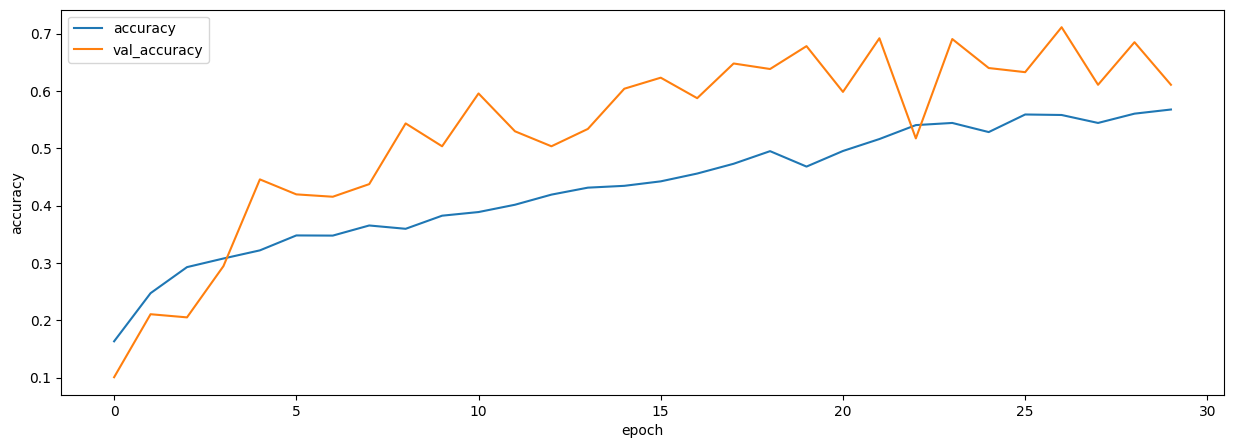

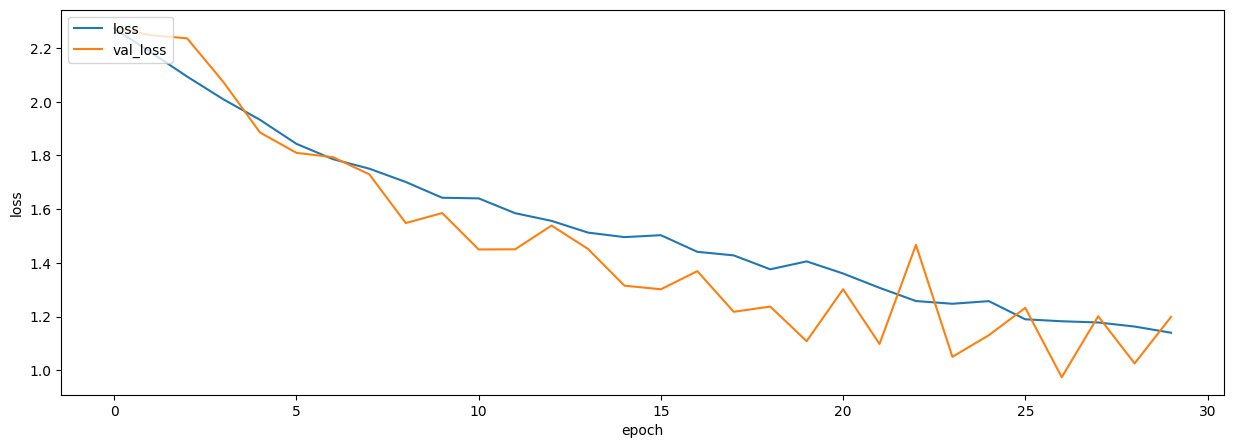

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.6082 - loss: 1.2193
Accuracy: 0.6221628785133362
Loss: 1.17893385887146
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step


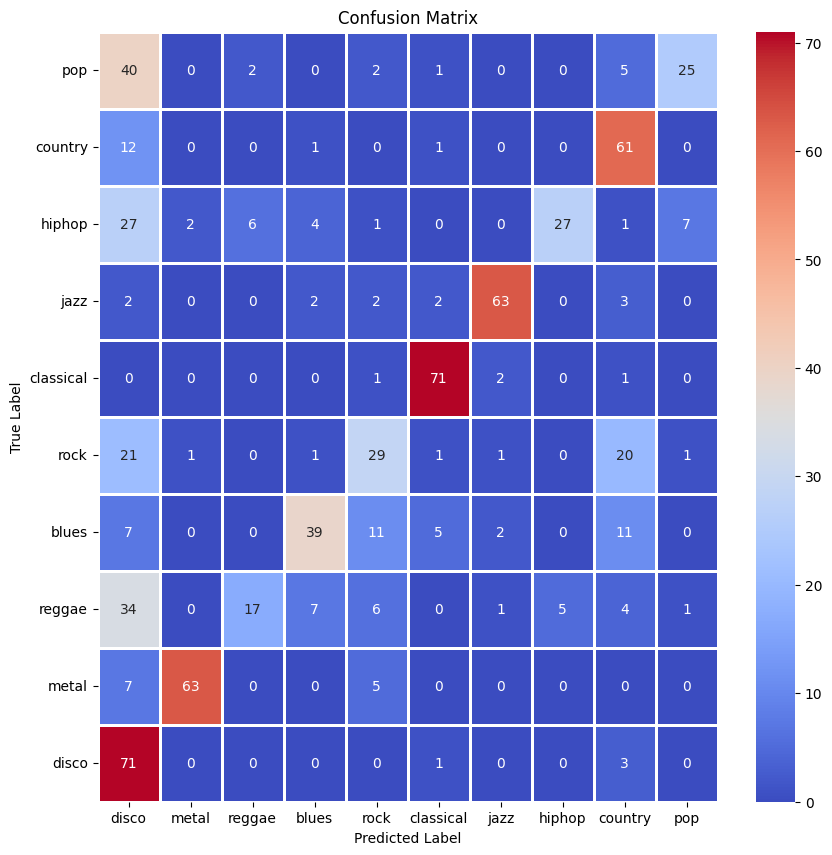

              precision    recall  f1-score   support

           0       0.32      0.95      0.48        75
           1       0.95      0.84      0.89        75
           2       0.68      0.23      0.34        75
           3       0.72      0.52      0.60        75
           4       0.51      0.39      0.44        75
           5       0.87      0.95      0.90        75
           6       0.91      0.85      0.88        74
           7       0.84      0.36      0.50        75
           8       0.56      0.81      0.66        75
           9       0.74      0.33      0.46        75

    accuracy                           0.62       749
   macro avg       0.71      0.62      0.62       749
weighted avg       0.71      0.62      0.62       749



In [11]:
plot_history(history, metric='accuracy')
plot_history(history, metric='loss')

evaluation = combined_model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

y_pred = combined_model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# Mel-Spectrogram

In [12]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size, cache=False)

100%|██████████| 4995/4995 [00:00<00:00, 246445.15it/s]


In [13]:
num_classes = 10

combined_model = build_combined_model()

combined_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

epochs = 30

history = combined_model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

combined_model.summary()


Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 241ms/step - accuracy: 0.1367 - loss: 2.2832 - val_accuracy: 0.2731 - val_loss: 2.2445
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - accuracy: 0.2364 - loss: 2.1868 - val_accuracy: 0.1458 - val_loss: 2.2414
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/step - accuracy: 0.2366 - loss: 2.1222 - val_accuracy: 0.2586 - val_loss: 2.1201
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.2606 - loss: 2.0566 - val_accuracy: 0.3274 - val_loss: 1.9830
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - accuracy: 0.2621 - loss: 2.0037 - val_accuracy: 0.3728 - val_loss: 1.8885
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.2751 - loss: 1.9633 - val_accuracy: 0.4182 - val_loss: 1.8086
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.2543 - loss: 1.9343 - val_accuracy: 0.3343 - val_loss: 1.8762
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - accuracy: 0.2926 - loss: 1

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ (None, 10)        │ 14,385,290 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 10)        │          0 │ functional_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 10)        │  1,562,378 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 20)        │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 20)        │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │     10,752 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │      5,130 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,869,404 (182.61 MB)

 Trainable params: 15,952,926 (60.86 MB)

 Non-trainable params: 10,624 (41.50 KB)

 Optimizer params: 31,905,854 (121.71 MB)

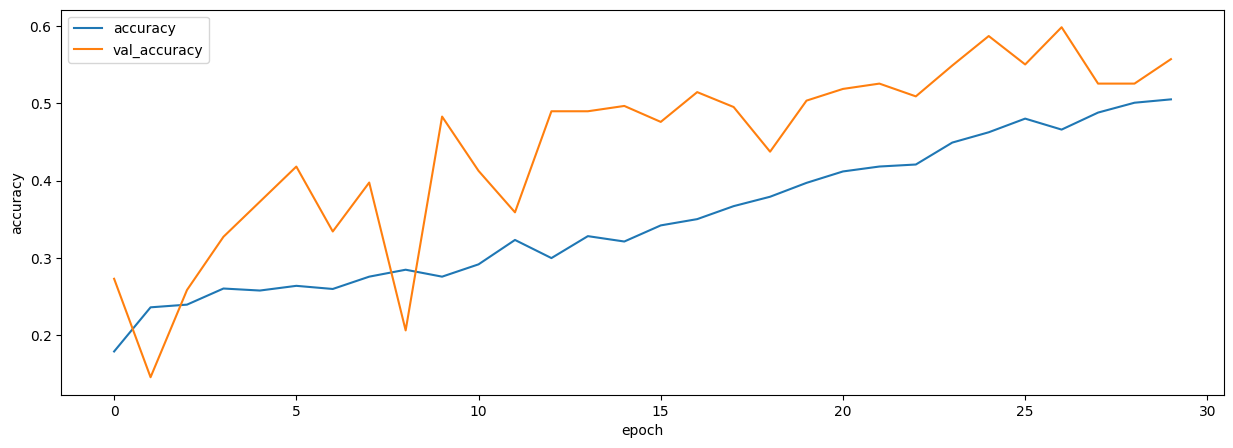

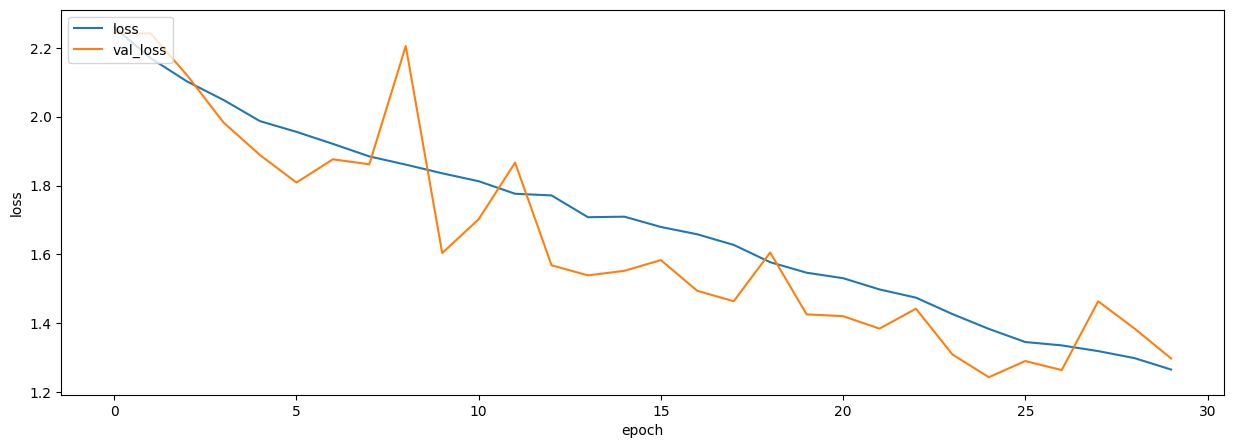

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5639 - loss: 1.3652
Accuracy: 0.5594125390052795
Loss: 1.3478503227233887
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step


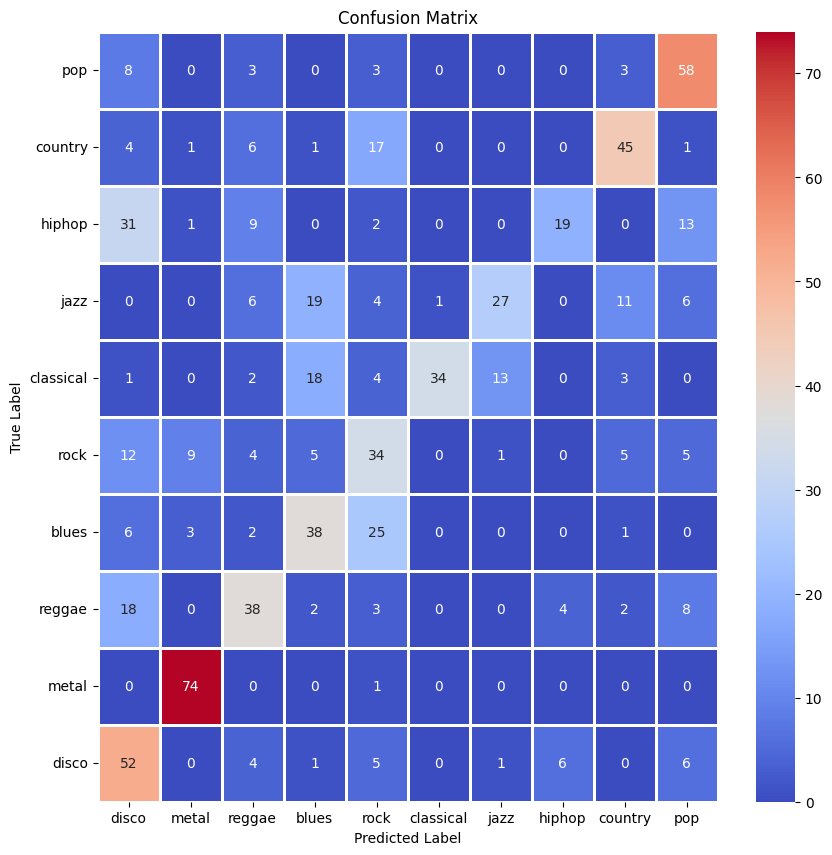

              precision    recall  f1-score   support

           0       0.39      0.69      0.50        75
           1       0.84      0.99      0.91        75
           2       0.51      0.51      0.51        75
           3       0.45      0.51      0.48        75
           4       0.35      0.45      0.39        75
           5       0.97      0.45      0.62        75
           6       0.64      0.36      0.47        74
           7       0.66      0.25      0.37        75
           8       0.64      0.60      0.62        75
           9       0.60      0.77      0.67        75

    accuracy                           0.56       749
   macro avg       0.61      0.56      0.55       749
weighted avg       0.61      0.56      0.55       749



In [15]:
plot_history(history, metric='accuracy')
plot_history(history, metric='loss')

evaluation = combined_model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

y_pred = combined_model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))